# Name Entity Recognition (NER) :-

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

We will be using Deep Learning approach to build a model using `Bidirectional LSTM` to idetify the NER from the any text file

The data that is used for training our model is from one of the kaggle compatition [link](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# EDA of Dataset

In [2]:
data = pd.read_csv('dataset/ner_dataset.csv', encoding= 'latin-1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
# Lets see how many sentence in total in the datset

data['Sentence #'].nunique()

47959

So, there are 47959 sentences ,  Lets put the NaN values of `Sentencce #` with the sentence number which then belong


In [4]:
data['Sentence #'].ffill(axis = 0 , inplace=True)
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
data.POS.unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

In [7]:
# Let's see hos many unique words & are there in the dataset

print('unique words:->' , data['Word'].nunique())
print('unique tags:->', data['Tag'].nunique())

unique words:-> 35178
unique tags:-> 17


So, there are 35178 unique words in the dataset and there are 17 tags for them

Let's create a dataset of the words.

In [8]:
words = list(set(data['Word'].values))
words.append('ENDPAD')   # appending "ENDPAD" word in the dataset of words for putting the its value in the pad_sequence
tags = list(set(data['Tag'].values))

In [9]:
np.shape(words)

(35179,)

In [10]:
num_words = len(words)
num_tags = len(tags)
print('Number of words ->',num_words)

Number of words -> 35179


Let's create an class that returns sentence out of these words in the dataset

In [11]:
class SentenceGetter:
    def __init__(self , data):
        self.data = data
        agg_func = lambda x : [(w , p ,t) for w,p,t in zip(x['Word'].values.tolist(),
                                                           x['POS'].values.tolist(),
                                                           x['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [i for i in self.grouped]

In [12]:
getter = SentenceGetter(data)

sentences = getter.sentences

sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [13]:
# Creating a vocabulary or a dictionary of the words

word2idx = {w:i+1 for i , w in enumerate(words)}
tags2idx = {t:i for i , t in enumerate(tags)}

print(word2idx['ENDPAD'])
tags2idx

35179


{'B-nat': 0,
 'I-org': 1,
 'I-gpe': 2,
 'B-eve': 3,
 'B-gpe': 4,
 'B-per': 5,
 'B-geo': 6,
 'B-org': 7,
 'B-tim': 8,
 'I-per': 9,
 'I-tim': 10,
 'I-art': 11,
 'I-nat': 12,
 'B-art': 13,
 'O': 14,
 'I-eve': 15,
 'I-geo': 16}

In [14]:
# lets find out how many words are in a sentence
print(len(sentences[0]))

24


let's create INPUT and OUTPUT feed for the model training

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 100  # To be safer side let's assume that a sentence have 50 words in it

x = [[word2idx[w[0]] for w in s] for s in sentences]

# Lets pad the input sentence that has not have 50 words in it
x = pad_sequences(sequences=x , maxlen=max_len , padding= 'post' , value = num_words -1)

y = [[tags2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(sequences= y , maxlen= max_len , padding= 'post', value= tags2idx['O'])

In [16]:
print('shape of x ->',x.shape)
print('shape of y ->' , y.shape)

shape of x -> (47959, 100)
shape of y -> (47959, 100)


In [17]:
# convert output "y" into one hot encoder

y = [to_categorical(i , num_classes=num_tags) for i in y]

In [18]:
y[0]

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [19]:
# spliting data into training and test set

from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x , y ,test_size = 0.1 , random_state = 42)

Building and compiling a BiLSTM 

In [20]:
from tensorflow.keras import Model , Input
from tensorflow.keras.layers import LSTM, Embedding , Dense
from tensorflow.keras.layers import TimeDistributed , Bidirectional , SpatialDropout1D

In [21]:
input_words = Input(shape= (max_len ,))

model = Embedding(input_dim = num_words + 1 , output_dim = max_len , input_length = max_len)(input_words)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(132 , return_sequences = True , recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags , activation = 'softmax'))(model)

model = Model(input_words , out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          3518000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 264)          246048    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 17)           4505      
Total params: 3,768,553
Trainable params: 3,768,553
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


Training model with per epoch visualization using Callbacks

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKerasTF

In [24]:
type(y_train)

list

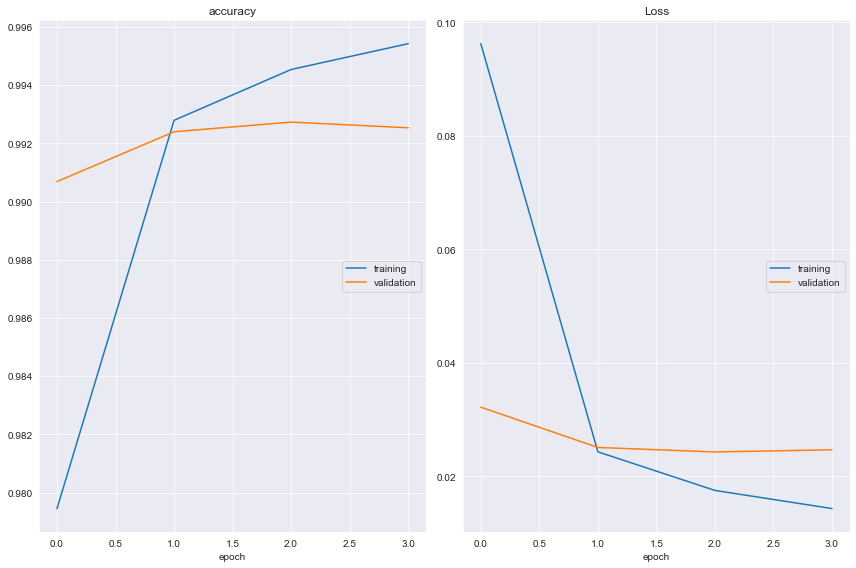

accuracy
	training         	 (min:    0.979, max:    0.995, cur:    0.995)
	validation       	 (min:    0.991, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.014, max:    0.096, cur:    0.014)
	validation       	 (min:    0.024, max:    0.032, cur:    0.025)


In [25]:
early_stopping = EarlyStopping( monitor= 'val_accuracy' , patience= 1 ,verbose=0 ,mode= 'max', restore_best_weights= False)

callbacks = [PlotLossesKerasTF() , early_stopping]

history = model.fit(
                    x_train , np.array(y_train),
                    validation_split=0.2,
                    batch_size = 32,
                    epochs = 5,
                    verbose = 0,
                    callbacks = callbacks
)

In [26]:
model.evaluate(x_test , np.array(y_test))

150/150 [==============================] - 4s 27ms/step - loss: 0.0246 - accuracy: 0.9926


[0.024599047377705574, 0.9926146864891052]

In [27]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))

Word           True 	Pred

------------------------------
They           O	O
temporarily    O	O
suspended      O	O
demonstrations O	O
in             O	O
Nepal          B-gpe	B-gpe
after          O	O
the            O	O
earthquake     O	O
in             O	O
China          B-geo	B-geo
,              O	O
but            O	O
recently       O	O
have           O	O
restarted      O	O
protests       O	O
.              O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led       O	O
army-led      

In [60]:
# model.save('Name_Entity_Recognition.h5')

## Data Cleaning

In [49]:
import os
import numpy as np
import pandas as pd

In [50]:
path = os.getcwd()

dataset_path = os.path.join(path ,'dataset')

text_path = os.path.join(dataset_path , 'text.task1_2-test（361p)')
image_path = os.path.join(dataset_path , 'task3-test（347p)')

In [51]:
print(text_path)
print(image_path)

C:\Users\iamra\Notebooks\internship_challenge\dataset\text.task1_2-test（361p)
C:\Users\iamra\Notebooks\internship_challenge\dataset\task3-test（347p)


In [52]:
text_files = os.listdir(text_path)
image_files = os.listdir(image_path)

In [53]:
print('Number of Test files ->',len(text_files))
print('Number of image files ->', len(image_files))

Number of Test files -> 361
Number of image files -> 347


In [54]:
text_files[0]

'X00016469670.txt'

In [55]:
image_files[0]

'X00016469670.jpg'

In [56]:
# Lets filter all the data from the text file that also exist in the image file

# Before filter the text file let's make a seperate folder to save the filtered file
new_folder = 'text_file'
dst_file = os.path.join(dataset_path,new_folder)
#os.makedirs(dst_file)

import shutil  # To copy the file 

def filter_text(text_file , image_file):
    text = []
    image = []
    for file in image_file:
        image.append(file[:-4])
        
    for file in text_file:
        text.append(file[:-4])
        
    for file in text:
        if file in image:
            file_name = file + '.txt'
            src_file = os.path.join(text_path , file_name)
            if os.path.isfile(src_file):
                shutil.copy(src_file , dst_file)

In [57]:
filter_text(text_files , image_files)

In [58]:
# Lets see how many files are in the text_file folder
print('Total Filtered file ->', len(os.listdir(dst_file)))

Total Filtered file -> 347


In [59]:
# Let's the clean the data to feed in the model

data = []
text_file = os.listdir(dst_file)

for file in text_file:
    path = os.path.join(dst_file , file)
    
    text = open(path , 'r')

    sentence = []
    for sent in text:
        sentence.append(sent)

    text.close()
    temp_data = []
    for sent in sentence:
        temp = sent.split(',')
        temp_data.append(temp[8:])
    
    temp_data_2 = []
    for i in range(len(temp_data)):
        for j in range(len(temp_data[i])):
            temp_data_2.append(temp_data[i][j])
          
    temp_data_3 = []
    for sent in temp_data_2:
        temp = sent.split()
        temp_data_3.append(temp)
    
    temp_data_4 = []
    for i in range(len(temp_data_3)):
        for j in range(len(temp_data_3[i])):
            temp_data_4.append(temp_data_3[i][j])
            
    data.append(temp_data_4)

In [60]:
word2idx['ENDPAD']

35179

In [73]:
x_sub = [[word2idx.get(w.lower() , 35179 ) for w in s] for s in data]

In [75]:
x_sub = pad_sequences(sequences=x_sub , maxlen=max_len , padding= 'post' , value = num_words -1)

In [79]:
prediction = model.predict(np.array(x_sub[0]))

In [100]:
pre = np.argmax(prediction , axis = -1)

In [101]:
for (word , pred) in zip(x_sub[0] , pre[0]):
    print(words[word-1] , '->' , tags[pred])

ENDPAD -> B-eve


In [103]:
pre

array([[ 3],
       [ 3],
       [14],
       [10],
       [ 1],
       [10],
       [ 3],
       [ 3],
       [10],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [14],
       [ 3],
       [ 3],
       [14],
       [14],
       [ 3],
       [14],
       [14],
       [ 3],
       [ 3],
       [14],
       [ 3],
       [14],
       [ 3],
       [ 3],
       [ 3],
       [14],
       [14],
       [14],
       [ 3],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [14],
       [ 3],
       [14],
       [ 3],
       [14],
       [14],
       [ 3],
       [10],
       [ 3],
       [ 3],
       [ 3],
       [14],
       [14],
       [ 9],
       [ 3],
       [ 3],
       [ 3],
       [10],
       [14],
       [14],
       [ 3],
       [ 3],
       [14],
       [ 3],
       [ 3],
       [ 3],
       [14],
       [14],
       [ 3],
       [ 3],